In [795]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import datetime

import seaborn as sns
sns.set()

# xgboost library
from xgboost import XGBClassifier

In [796]:
# import test and train data

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')

In [797]:
df_test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [798]:
df_train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [799]:
# we can get useful features from pickup time
# 1. day of week 2. is_busy_time
# for that I will use following functions
# morning 7 - 10 and evening 5 - 8 is busy time

def get_day_of_week(date):
    date_object = datetime.datetime.strptime(date, '%m/%d/%Y %H:%M').date()
    return date_object.weekday()

def get_time_only(date):
    time = date.split(" ")[1]
    return time


def is_pickup_time_busy(time):
    hour = int(time.split(":")[0])
    
    if (7 <= hour <= 9 or 17 <= hour <= 19):
        return 1
    else: 
        return 0

In [800]:
# drop, drop_time in both train and test dataset
# this is useless feature

df_train.pop("drop_time")
df_test.pop("drop_time")

0         2/1/2020 0:53
1         2/1/2020 2:13
2         2/1/2020 5:28
3         2/1/2020 5:38
4         2/1/2020 7:14
             ...       
8571    3/16/2020 21:56
8572    3/16/2020 22:22
8573    3/16/2020 22:09
8574    3/16/2020 22:34
8575    3/16/2020 23:26
Name: drop_time, Length: 8576, dtype: object

In [801]:
df_train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [802]:
# change pick_time -> weekday of pickup and is_pickup_time_busy

pickup_train = df_train.pop("pickup_time")
pickup_test = df_test.pop("pickup_time")

In [803]:
# create weekday of pickup and is_pickup_time_busy for training dataset

pickup_train = pd.Series(pickup_train)
pick_up_day_of_week_train = pickup_train.map(get_day_of_week)
pickup_train_time = pickup_train.map(get_time_only)
pick_up_is_busy_time_train = pickup_train_time.map(is_pickup_time_busy)

pick_up_is_busy_time_train.head()

0    0
1    0
2    0
3    0
4    0
Name: pickup_time, dtype: int64

In [804]:
# create weekday of pickup and is_pickup_time_busy for testing dataset

pickup_test = pd.Series(pickup_test)
pick_up_day_of_week_test = pickup_test.map(get_day_of_week)
pickup_test_time = pickup_test.map(get_time_only)
pick_up_is_busy_time_test = pickup_test_time.map(is_pickup_time_busy)

In [805]:
# merge weekday of pickup and is_pickup_time_busy with training dataset

df_pick_up_day_of_week_train = pd.DataFrame({
    'pickup_dayweek': pick_up_day_of_week_train
})

df_pick_up_is_busy_time_train = pd.DataFrame({
    'is_pickup_busy_time': pick_up_is_busy_time_train
})

new_df_train = pd.concat([df_train, df_pick_up_day_of_week_train], axis=1, sort=True)


In [806]:
# merge weekday of pickup and is_pickup_time_busy with testing dataset

df_pick_up_day_of_week_test = pd.DataFrame({
    'pickup_dayweek': pick_up_day_of_week_test
})

df_pick_up_is_busy_time_test = pd.DataFrame({
    'is_pickup_busy_time': pick_up_is_busy_time_test
})

new_df_test = pd.concat([df_test, df_pick_up_day_of_week_test], axis=1, sort=True)

In [807]:
# replace pick_lat 	pick_lon 	drop_lat 	drop_lon with actual distance between two locations
# so I will use goodle distance matrix api
# so, drop those four columns in test and train dataset
column = ['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon']

for key in column:
    new_df_test.pop(key)
    new_df_train.pop(key)

In [808]:
new_df_train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_dayweek
0,189123628,10.5,834.0,56.0,0.0000,64.0,270.32,correct,4
1,189125358,10.5,791.0,47.0,0.0000,134.0,197.85,correct,4
2,189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,correct,4
3,189127273,10.5,598.0,271.0,15.6638,68.0,82.30,correct,4
4,189128020,NaN,NaN,NaN,NaN,NaN,358.39,correct,4


In [809]:
new_df_test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_dayweek
0,213284604,10.5,924,42,2.4486,148,289.27,5
1,213286352,10.5,4249,20,0.0000,91,1912.70,5
2,213293973,10.5,1552,255,2.6588,23,394.00,5
3,213294622,10.5,462,16,0.0000,198,154.32,5
4,213298687,10.5,814,392,12.3692,69,147.47,5


In [810]:
# using pickup and drop coordinates to calculate road distance using Google distance matrix api.
# script writes in a separate file and stroe the distance in a csv file for both test and train data

df_distances_train = pd.read_csv("distances_train.csv")["distance"]
df_distances_test = pd.read_csv("distances_test.csv")["distance"]

In [811]:
#changes zero values to Nan. Then later can fillup for Nan values

df_distances_train = df_distances_train.replace({0.0:np.nan})

In [812]:
distance_train = pd.DataFrame({
    'distance': df_distances_train
})

new_df_train = pd.concat([new_df_train, distance_train], axis=1, sort=True)

In [813]:
new_df_train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_dayweek,distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,270.32,correct,4,7.923
1,189125358,10.5,791.0,47.0,0.0000,134.0,197.85,correct,4,5.219
2,189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,correct,4,9.183
3,189127273,10.5,598.0,271.0,15.6638,68.0,82.30,correct,4,1.528
4,189128020,NaN,NaN,NaN,NaN,NaN,358.39,correct,4,9.983


In [814]:
distance_test = pd.DataFrame({
    'distance': df_distances_test
})

new_df_test = pd.concat([new_df_test, distance_test], axis=1, sort=True)

In [815]:
new_df_test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_dayweek,distance
0,213284604,10.5,924,42,2.4486,148,289.27,5,8.568
1,213286352,10.5,4249,20,0.0000,91,1912.70,5,63.545
2,213293973,10.5,1552,255,2.6588,23,394.00,5,7.333
3,213294622,10.5,462,16,0.0000,198,154.32,5,3.987
4,213298687,10.5,814,392,12.3692,69,147.47,5,3.036


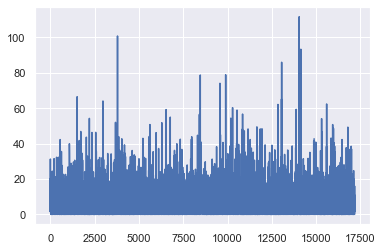

In [816]:
new_df_train["distance"].plot()

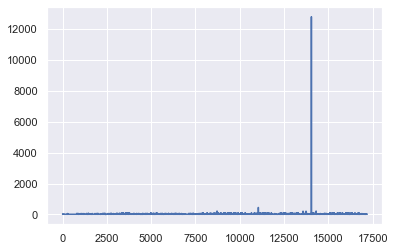

In [939]:
new_df_train["additional_fare"].plot()

In [940]:
# remove outliers in additional fair

df_train_1 = new_df_train[~(np.abs(new_df_train.additional_fare-new_df_train.additional_fare.mean()) > (3*new_df_train.additional_fare.std()))]

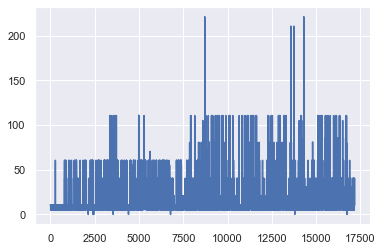

In [941]:
df_train_1["additional_fare"].plot()

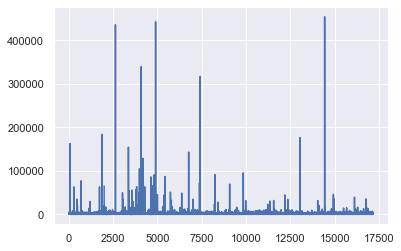

In [942]:
df_train_1["duration"].plot()

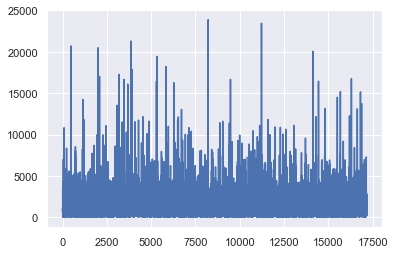

In [943]:
# remove outliers in duration

df_train_3 = df_train_1[~(np.abs(df_train_1.duration-df_train_1.duration.mean()) > (3*df_train_1.duration.std()))]

df_train_3["duration"].plot()

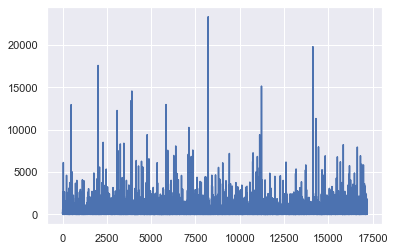

In [944]:
df_train_3["meter_waiting"].plot()

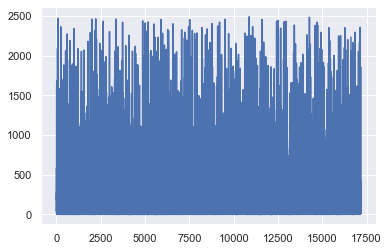

In [945]:
# remove outliers in meter_waiting

df_train_4 = df_train_3[~(np.abs(df_train_3.meter_waiting-df_train_3.meter_waiting.mean()) > (3*df_train_3.meter_waiting.std()))]

df_train_4["meter_waiting"].plot()

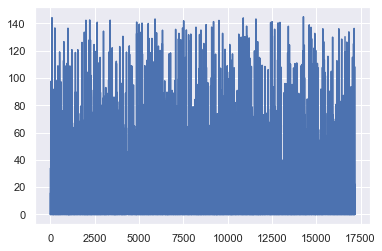

In [946]:
df_train_4["meter_waiting_fare"].plot()

# it seams meter_wating and meter_wating_fair is linearly dependent. So, automatically remove outlliers

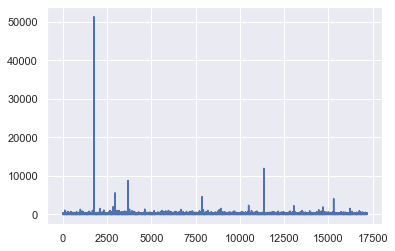

In [947]:
df_train_4["meter_waiting_till_pickup"].plot()

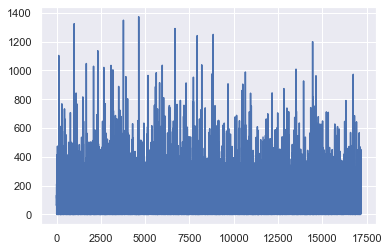

In [948]:
# remove outliers in meter_waiting_till_pickup

df_train_5 = df_train_4[~(np.abs(df_train_4.meter_waiting_till_pickup-df_train_4.meter_waiting_till_pickup.mean()) > (3*df_train_4.meter_waiting_till_pickup.std()))]

df_train_5["meter_waiting_till_pickup"].plot()

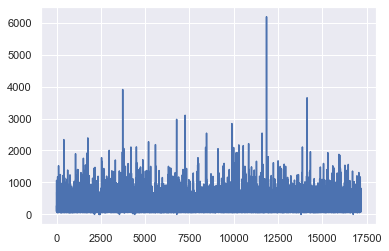

In [949]:
df_train_5["fare"].plot()

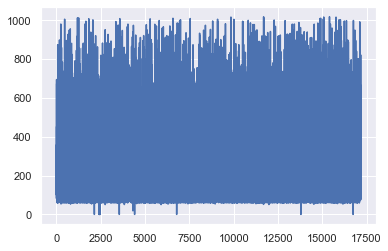

In [950]:
# remove outliers in meter_waiting_till_pickup

df_train_6 = df_train_5[~(np.abs(df_train_5.fare-df_train_5.fare.mean()) > (3*df_train_5.fare.std()))]

df_train_6["fare"].plot()

In [951]:
df_train_5.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_dayweek,distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,270.32,correct,4,7.923
1,189125358,10.5,791.0,47.0,0.0000,134.0,197.85,correct,4,5.219
2,189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,correct,4,9.183
3,189127273,10.5,598.0,271.0,15.6638,68.0,82.30,correct,4,1.528
4,189128020,NaN,NaN,NaN,NaN,NaN,358.39,correct,4,9.983


In [952]:
# check for null values in train data
bool_series = pd.isnull(df_train_5["meter_waiting_till_pickup"])


df_train_5[bool_series]  

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_dayweek,distance
4,189128020,NaN,NaN,NaN,NaN,NaN,358.39,correct,4,9.983
31,189164831,NaN,NaN,NaN,NaN,NaN,NaN,incorrect,4,3.563
91,189231599,NaN,NaN,NaN,NaN,NaN,196.50,incorrect,4,2.559
253,189393356,NaN,NaN,NaN,NaN,NaN,188.71,incorrect,5,1.430
811,190066074,NaN,NaN,NaN,NaN,NaN,NaN,incorrect,1,3.377
...,...,...,...,...,...,...,...,...,...,...
16994,213449192,NaN,NaN,NaN,NaN,NaN,NaN,incorrect,3,5.293
17033,213510465,NaN,NaN,NaN,NaN,NaN,NaN,incorrect,4,0.023
17052,213538831,NaN,NaN,NaN,NaN,NaN,NaN,incorrect,4,NaN
17123,213674502,NaN,NaN,NaN,NaN,NaN,NaN,incorrect,4,18.059


In [953]:
# check for null values in test data
bool_series_test = pd.isnull(new_df_test["additional_fare"])


new_df_test[bool_series_test]  

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_dayweek,distance


In [954]:
df_train_5.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_dayweek,distance
count,1.685800e+04,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16722.000000,16858.000000,16738.000000
mean,2.014687e+08,12.942813,1308.158081,266.487752,11.374003,104.881424,280.310246,2.912208,6.276258
std,7.454996e+06,12.629529,1143.489161,379.272557,22.026845,118.333788,246.009736,1.942858,6.112610
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,1.948069e+08,10.500000,541.000000,32.000000,0.000000,26.000000,124.267500,1.000000,2.330000
50%,2.013751e+08,10.500000,991.000000,120.000000,0.000000,73.000000,207.855000,3.000000,4.616000
75%,2.083328e+08,10.500000,1739.000000,332.000000,12.942600,143.000000,355.365000,5.000000,8.316750
max,2.138173e+08,221.000000,17270.000000,2490.000000,144.817200,1373.000000,6185.320000,6.000000,93.302000


In [955]:
# data cleaning for train dataset aka fillup missing values

df_train_n = df_train_5.interpolate(methpd="time")

df_train_n[bool_series]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_dayweek,distance
4,189128020,10.50,2002.5,226.5,7.83190,90.0,358.390,correct,4,9.983
31,189164831,7.75,1081.5,162.5,8.80330,33.0,249.850,incorrect,4,3.563
91,189231599,10.50,456.0,75.0,0.87450,60.5,196.500,incorrect,4,2.559
253,189393356,10.50,890.5,120.0,6.93600,254.0,188.710,incorrect,5,1.430
811,190066074,22.75,1985.0,893.0,51.62290,22.0,313.360,incorrect,1,3.377
...,...,...,...,...,...,...,...,...,...,...
16994,213449192,7.75,284.0,97.5,5.24700,58.5,138.500,incorrect,3,5.293
17033,213510465,7.75,887.0,266.0,15.12885,125.0,160.570,incorrect,4,0.023
17052,213538831,20.50,1365.0,110.5,0.00000,67.5,224.505,incorrect,4,6.889
17123,213674502,17.75,860.0,175.5,5.56765,20.0,162.990,incorrect,4,18.059


In [956]:
df_train_n.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_dayweek,distance
count,1.685800e+04,16858.000000,16858.000000,16858.000000,16858.000000,16858.000000,16858.000000,16858.000000,16858.000000
mean,2.014687e+08,12.943291,1308.733776,266.306739,11.361439,104.831801,280.242591,2.912208,6.274671
std,7.454996e+06,12.587586,1139.818685,378.048918,21.955088,117.898290,245.302410,1.942858,6.100282
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,1.948069e+08,10.500000,545.000000,32.000000,0.000000,26.000000,124.720000,1.000000,2.336250
50%,2.013751e+08,10.500000,993.000000,120.000000,0.000000,73.000000,208.190000,3.000000,4.620500
75%,2.083328e+08,10.500000,1740.000000,332.000000,12.942600,143.000000,355.435000,5.000000,8.305000
max,2.138173e+08,221.000000,17270.000000,2490.000000,144.817200,1373.000000,6185.320000,6.000000,93.302000


In [957]:
trip_id = df_train_n.pop('tripid')

In [958]:
Y = df_train_n['label']

In [959]:
def binarization(label):
    if (label == "correct"):
        return 1
    else:
        return 0
    
Y =  Y.apply(lambda x: binarization(x))
X = df_train_n.drop('label', axis=1)

Y.unique()

array([1, 0])

In [960]:
X

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_dayweek,distance
0,10.5,834.0,56.0,0.0000,64.0,270.32,4,7.923
1,10.5,791.0,47.0,0.0000,134.0,197.85,4,5.219
2,10.5,1087.0,80.0,0.0000,61.0,301.64,4,9.183
3,10.5,598.0,271.0,15.6638,68.0,82.30,4,1.528
4,10.5,2002.5,226.5,7.8319,90.0,358.39,4,9.983
...,...,...,...,...,...,...,...,...
17171,10.5,838.0,93.0,5.4219,451.0,198.26,4,4.364
17172,10.5,2151.0,428.0,0.0000,39.0,581.23,4,16.023
17173,10.5,263.0,9.0,0.0000,110.0,76.20,4,1.400
17174,10.5,858.0,115.0,0.0000,317.0,133.31,4,3.390


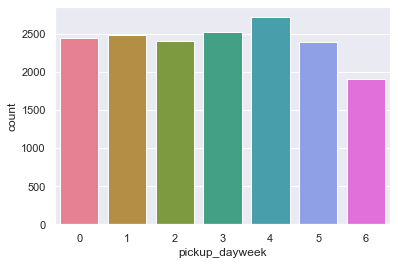

In [961]:
sns.countplot(x='pickup_dayweek', data=X, palette='husl')
plt.show()

Text(0.5, 1, 'Heatmap of Correlation Matrix')

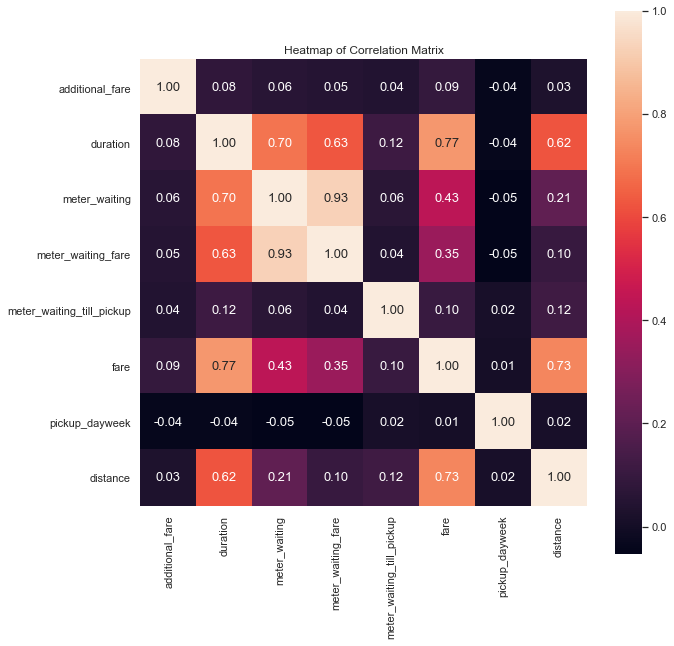

In [962]:
# find the corelation between inputs
num_cols = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'pickup_dayweek', 'is_pickup_busy_time', 'distance']

corr=X.corr()
corr = (corr)
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 13},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')

In [963]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


OHE = OneHotEncoder(sparse=False)
days_of_week = OHE.fit_transform(X[['pickup_dayweek']])

cat_var_names = ['pickup_dayweek']

num_variables = X.drop(cat_var_names, axis=1)

scaler = StandardScaler().fit(num_variables)
stdz_num_variables = scaler.transform(num_variables)

final_X = np.hstack((days_of_week,stdz_num_variables))

In [964]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

test = SelectKBest(k=9)
fit = test.fit(final_X,Y)

np.set_printoptions(precision=1)
print(fit.scores_)
features = fit.transform(final_X)

X_train, X_test, y_train, y_test = train_test_split(features,Y, test_size=0.25, random_state=44)

[4.3e-03 1.4e+00 1.7e-01 7.4e+00 3.4e-01 1.8e+00 1.7e+00 2.7e+02 4.7e+01
 2.9e+01 8.1e-02 1.1e+02 5.9e+02 4.6e+00]


In [1253]:
# Using SVM

In [965]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

estimator = SVC(kernel='rbf')

selector = estimator.fit(X_train,y_train)

y_predict_test = selector.predict(X_test)
y_predict_train = selector.predict(X_train)
print(accuracy_score(y_train, y_predict_train))
print(accuracy_score(y_test, y_predict_test))

0.9428933006406707
0.9444839857651246


In [966]:
X_predict = new_df_test.drop('tripid', axis=1)


OHE_test = OneHotEncoder(sparse=False)
days_of_week_test = OHE_test.fit_transform(X_predict[['pickup_dayweek']])

# cat_variables = np.hstack((days_of_week))
cat_var_names_test = ['pickup_dayweek']

num_variables_test = X_predict.drop(cat_var_names_test, axis=1)

scaler_test = StandardScaler().fit(num_variables_test)
stdz_num_variables_test = scaler_test.transform(num_variables_test)

# stdz_num_variables.shape

final_X_test = np.hstack((days_of_week_test,stdz_num_variables_test))
final_X_test.shape

(8576, 14)

In [967]:
feature_prediction = fit.transform(final_X_test)

predicted_values = selector.predict(feature_prediction).tolist()

In [968]:
svm_output = pd.DataFrame(new_df_test['tripid']) 
svm_output['prediction']= predicted_values
svm_output.to_csv('ride_svm_160723B.csv', encoding='utf-8', index=False)

In [1251]:
# Using Random Forest

In [1207]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=60)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1208]:
rfc_pred = rfc.predict(X_test)
print(accuracy_score(y_test, rfc_pred))

0.9478054567022538


In [975]:
rf_feature_prediction = fit.transform(final_X_test)
rf_predicted_values = rfc.predict(rf_feature_prediction).tolist()

In [976]:
rf_output = pd.DataFrame(new_df_test['tripid']) 
rf_output['prediction']= rf_predicted_values
rf_output.to_csv('ride_rf_160723B.csv', encoding='utf-8', index=False)

In [1252]:
# using XG Boost

In [1243]:
model = XGBClassifier(learning_rate=0.5, max_depth=4, n_estimators=32)

In [1244]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=32, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [1245]:
predict_train = model.predict(X_train)

In [1246]:
accuracy_score(y_train,predict_train)

0.9577631891165072

In [1247]:
predict_test = model.predict(X_test)

In [1248]:
accuracy_score(y_test,predict_test)

0.9511269276393831

In [1249]:
xg_feature_prediction = fit.transform(final_X_test)
xg_predicted_values = model.predict(xg_feature_prediction).tolist()

In [1250]:
xg_output = pd.DataFrame(new_df_test['tripid']) 
xg_output['prediction']= rf_predicted_values
xg_output.to_csv('ride_xg_160723B.csv', encoding='utf-8', index=False)